# In this Notebook:
## Paramter Scans
- 1D paramter scans 

## Minimization
- plot the minimization process, ie the log likelihood for all iteration steps

## Error estimation
- plot the error for a range of epsilons of the finit differnce estimation of the hessian, check if the estimation is numerically stable, ie close to constant for a range of epsilons

## Compare final and initial parameters


In [1]:
from read_ggp_run import *

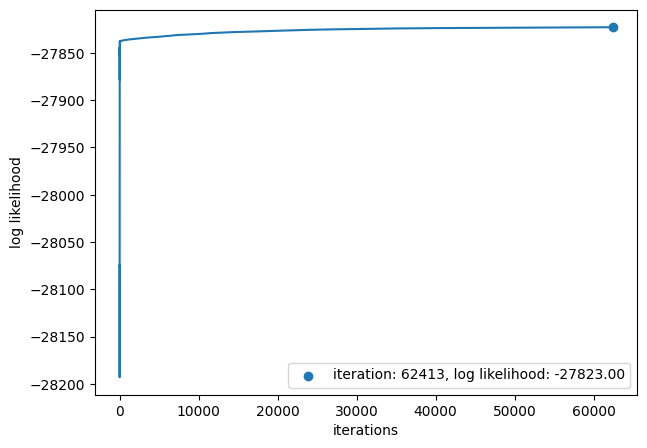

KeyError: -1

In [7]:
# -------------------------------------------------- #
# Setup
# -------------------------------------------------- #

paramter_settings = {'mean_lambda': 'bound',
                    'gamma_lambda': 'bound',
                    'var_lambda': 'bound',
                    'mean_q': 'bound',
                    'gamma_q': 'bound',
                    'var_q':'bound',
                    'beta':'bound',
                    'var_x':'bound',
                    'var_g':'bound',
                    'var_dx':'bound',
                    'var_dg':'free'} 


directory_tmpl = '../data/scaled_noise_n250_var_g_sizer/scaled_noise_n250_var_g_sizer_{:d}'
sample_tmpl = 'scaled_noise_n250_var_g_sizer_{:d}'
# -------------------------------------------------- #

for i in np.arange(0,1):
    directory = directory_tmpl.format(i)
    sample = sample_tmpl.format(i)

    filebase = default_filebase(directory, sample) # default
    save_plots = True


    # get all needed filenames
    dat_file = get_data_file(directory, sample)

    minimization_iter_file, minimization_final_file = get_minimization_file(filebase, paramter_settings)
    scan_files = get_scan_files(filebase, paramter_settings)

    prediction_file_f, prediction_file_b, prediction_file = get_prediction_files(filebase)

    if save_plots:
        plot_file = filebase
    else:
        plot_file = None 


    # plots
    if len(scan_files)>0:
        plot_1dscans(scan_files, plot_file)    

    plot_minimization(minimization_iter_file, plot_file)
    ll = read_iteration_process(minimization_iter_file)
    print(np.max(ll[]), ll[-1])

    final_params = pd.read_csv(minimization_final_file, nrows=11)['final']
    errors = pd.read_csv(minimization_final_file, skiprows=14)
        
    plot_errors(errors, final_params, plot_file)

    compare_init_final(minimization_iter_file, plot_file, ["var_g", "var_dg"])
